<!-- # Summarization model -->

In [4]:
import torch
import torch.nn as nn
import json

seed = 42
torch.manual_seed(seed)  # PyTorch CPU
torch.cuda.manual_seed(seed)  # PyTorch GPU
torch.cuda.manual_seed_all(seed)  # Multi-GPU

# Check if GPU is available
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU count: {torch.cuda.device_count()}")
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
print(f"Using device: {device}")

# import os


PyTorch version: 2.4.1+cu118
CUDA available: True
CUDA version: 11.8
GPU count: 1
Using device: cuda


# Load dataset

In [10]:

from datasets import load_dataset

ds = load_dataset("FrancophonIA/french-to-english", split="train", streaming=True)
print(ds)

IterableDataset({
    features: Unknown,
    num_shards: 1
})


# Get Tokenizer - BartTokenizer with 50265 vocab size

In [11]:
from transformers import BartTokenizer

tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
VOCAB_SIZE = tokenizer.vocab_size

SRC_MAX_SEQ = 50
TGT_MAX_SEQ = 50
max_examples = 600

# Prepare data - save data

In [12]:
from transformers import pipeline

model_ckpt = "papluca/xlm-roberta-base-language-detection"
pipe = pipeline("text-classification", model=model_ckpt, device=device)

In [13]:

inputs = []
outputs = []
i = 0
for data in ds:
    src_sentence = tokenizer.encode(str(data['en']))
    tgt_sentence = tokenizer.encode(str(data['fr']))
    if len(src_sentence) <= SRC_MAX_SEQ and len(tgt_sentence) <= TGT_MAX_SEQ:
        try:
            if not data.get('fr') or not isinstance(data['fr'], str):
                continue  # Skip invalid entries
            else:
                res = pipe(data['fr'], top_k=1, truncation=True)[0]['label']
                if res == 'fr':       
                    inputs.append(src_sentence)
                    outputs.append(tgt_sentence)
                    i += 1
        except Exception as e:
            print(f"Error {e}")
            continue       
    if i == max_examples:
        break
# Save as JSON
with open('tokenized_data.json', 'w') as f:
    json.dump({'inputs': inputs, 'outputs': outputs}, f)

d:\Users\mlaudan\Documents\mag\text_summarization\.venv\lib\site-packages\transformers\models\xlm_roberta\modeling_xlm_roberta.py:371: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


# Load data

In [ ]:
inputs = []
outputs = []

with open('tokenized_data.json', 'r') as f:
    data = json.load(f)
    inputs = data['inputs'][:max_examples]
    outputs = data['outputs'][:max_examples]
print(len(inputs), len(outputs))
# for inp, out in zip(inputs, outputs):
#     out = tokenizer.decode(out, skip_special_tokens=True)
#     inp = tokenizer.decode(inp, skip_special_tokens=True)
#     print(inp)
#     print(out)
#     print()
#     res = pipe(out, top_k=1, truncation=True)[0]['label']
#     if res != 'fr':
#         print(res, out)

600 600
Site map
Plan du site

Feedback
Rétroaction

Credits
Crédits

What is light ?
Qu’est-ce que la lumière?

The sky of the first inhabitants A contemporary vison of the Universe Astronomy for everyone
Le ciel des premiers habitants La vision contemporaine de l'Univers L’astronomie pour tous

Cartoon
Bande dessinée

Astronomers Introduction Introduction video What is Astronomy?
Astronomes Introduction Vidéo d'introduction Qu'est-ce que l'astronomie?

The name is derived from the Greek root astron for star, and nomos for arrangement or law.
Son nom vient du grec astron, qui veut dire étoile et nomos, qui veut dire loi.

It prompts us to ask the deepest existential questions:
L'astronomie évoque donc aussi les grandes questions « existentielles » :

Who are we?
Où sommes-nous?

Where did we come from?
D'où venons-nous?

Are we alone?
Sommes-nous seuls?

The lure of these universal enigmas was the spark that ignited the passion of many of today’s famous astronomers.
L'attrait exercé p

# Clean data

In [17]:
"""To set determined len for src and tgt --> also with pad tokens"""


def clean_data(sentences, max_seq_length):
    for i, sentence in enumerate(sentences):
        if len(sentence) < max_seq_length:
            sentences[i] = sentence + [tokenizer.pad_token_id] * (max_seq_length - len(sentence))


clean_data(inputs, SRC_MAX_SEQ)
clean_data(outputs, TGT_MAX_SEQ)

In [18]:
for step, (inp, out) in enumerate(zip(inputs, outputs)):
    print(tokenizer.decode(inp, skip_special_tokens=True), '######', tokenizer.decode(out, skip_special_tokens=True))
    if step == 10:
        break

Site map ###### Plan du site
Feedback ###### Rétroaction
Credits ###### Crédits
What is light ? ###### Qu’est-ce que la lumière?
The sky of the first inhabitants A contemporary vison of the Universe Astronomy for everyone ###### Le ciel des premiers habitants La vision contemporaine de l'Univers L’astronomie pour tous
Cartoon ###### Bande dessinée
Astronomers Introduction Introduction video What is Astronomy? ###### Astronomes Introduction Vidéo d'introduction Qu'est-ce que l'astronomie?
The name is derived from the Greek root astron for star, and nomos for arrangement or law. ###### Son nom vient du grec astron, qui veut dire étoile et nomos, qui veut dire loi.
It prompts us to ask the deepest existential questions: ###### L'astronomie évoque donc aussi les grandes questions « existentielles » :
Who are we? ###### Où sommes-nous?
Where did we come from? ###### D'où venons-nous?


In [19]:
inputs = torch.tensor(inputs)
targets = torch.tensor(outputs)
assert len(inputs) == len(targets), "Number of articles and summaries must be the same"
print('Max src seq len:', SRC_MAX_SEQ)
print('Max tgt seq len:', TGT_MAX_SEQ)
print('Number of examples:', len(inputs))
print("Number of vocab size:", VOCAB_SIZE)

Max src seq len: 50
Max tgt seq len: 50
Number of examples: 600
Number of vocab size: 50265


# Custom Dataset and DataLoader with train and val data (80%, 20%)

In [20]:
from torch.utils.data import random_split, Dataset


class CustomDataset(Dataset):
    def __init__(self, inputs: torch.Tensor, outputs: torch.Tensor):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]


dataset = CustomDataset(inputs, targets)
train_data, val_data = random_split(dataset, [0.8, 0.2])
print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(val_data)}")

Number of training samples: 480
Number of validation samples: 120


In [21]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128  # TODO: expand batch size for transformer architecture

train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    # drop_last=True
)

val_loader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    # drop_last=True
)

print(f"Number of batches in training set: {len(train_loader)}")
print(f"Number of batches in validation set: {len(val_loader)}")


Number of batches in training set: 4
Number of batches in validation set: 1


In [22]:
print(tokenizer.decode(train_loader.dataset[0][0], skip_special_tokens=True) )
print(tokenizer.decode(train_loader.dataset[0][1], skip_special_tokens=True) )

It was under his guidance that astronomy really took off in Canada, developing first at the national scale and then rising to international stature.
C'est en effet sous sa gouverne que l'astronomie canadienne prend son véritable envol et se développe au niveau national et international.


In [23]:
import math


class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads 

        self.W_q = nn.Linear(d_model, d_model)  # Query transformation
        self.W_k = nn.Linear(d_model, d_model)  # Key transformation
        self.W_v = nn.Linear(d_model, d_model)  # Value transformation
        self.W_o = nn.Linear(d_model, d_model)  # Output transformation

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # TODO: use F..scaled_dot_product_attention
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        attn_probs = torch.softmax(attn_scores, dim=-1)

        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [24]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        # Assumption: GELU outperforms ReLU which leads to 'ReLU dead neuron problem': https://arxiv.org/pdf/1606.08415
        self.gelu = nn.GELU(approximate='tanh')

    def forward(self, x):
        return self.fc2(self.gelu(self.fc1(x)))

In [25]:
"""NOTE: There is no evidence that positional encoding is better than simple learnable embeddings."""

#
# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, max_seq_length):
#         super(PositionalEncoding, self).__init__()
#
#         pe = torch.zeros(max_seq_length, d_model)
#         position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
#
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#
#         self.register_buffer('pe', pe.unsqueeze(0))
#
#     def forward(self, x):
#         return x + self.pe[:, :x.size(1)]

'NOTE: There is no evidence that positional encoding is better than simple learnable embeddings.'

In [26]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)  # TODO: one dropout layer or two?

    def forward(self, x, mask):
        # Normalization before sub-blocks: as described at: https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf
        residual_x = self.norm1(x)  # residual_x described at: https://arxiv.org/pdf/1904.10509
        attn_output = self.self_attn(residual_x, residual_x, residual_x, mask)
        x = x + self.dropout(attn_output)
        residual_x = self.norm2(x)  # Normalization before sub-blocks
        ff_output = self.feed_forward(residual_x)
        x = x + self.dropout(ff_output)
        return x

In [27]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        # Normalization before sub-blocks: as described at: https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf
        residual_x = self.norm1(x)
        attn_output = self.self_attn(residual_x, residual_x, residual_x, tgt_mask)
        x = x + self.dropout(attn_output)
        residual_x = self.norm2(x)  # Normalization before sub-blocks
        attn_output = self.cross_attn(residual_x, enc_output, enc_output, src_mask)
        x = x + self.dropout(attn_output)
        residual_x = self.norm3(x)  # Normalization before sub-blocks
        ff_output = self.feed_forward(residual_x)
        x = x + self.dropout(ff_output)
        return x

In [28]:



class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_src_seq_len,
                 max_tgt_seq_len, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        # self.src_positional_encoding = PositionalEncoding(d_model, max_src_seq_len)
        # self.tgt_positional_encoding = PositionalEncoding(d_model, max_tgt_seq_len)
        self.src_positional_encoding = nn.Embedding(max_src_seq_len,
                                                    d_model)  # instead of cos and sin functions (in PositionalEncoding)
        self.tgt_positional_encoding = nn.Embedding(max_tgt_seq_len, d_model)

        self.encoder_layers = nn.ModuleList(
            [EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList(
            [DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        # One more LayerNorm as described: https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf
        self.ln_f = nn.LayerNorm(d_model)
        self.output_layer = nn.Linear(d_model, tgt_vocab_size,
                                      bias=False)  # bias=False as depicted: https://github.com/karpathy/nanoGPT/blob/master/model.py
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != tokenizer.pad_token_id).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != tokenizer.pad_token_id).unsqueeze(1).unsqueeze(3)
        src_mask, tgt_mask = src_mask.to(device), tgt_mask.to(device)
        seq_length = tgt.size(1)
        casual_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
        casual_mask = casual_mask.to(device)
        tgt_mask = tgt_mask & casual_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        # src_embedded = self.dropout(self.src_positional_encoding(self.encoder_embedding(src)))
        # tgt_embedded = self.dropout(self.tgt_positional_encoding(self.decoder_embedding(tgt)))

        src_pos = torch.arange(0, src.size(1)).to(device)  # [0, 1, 2 ... src.size(1)]
        src_pos = self.src_positional_encoding(src_pos)
        src_embedded = self.encoder_embedding(src)
        src_embedded = self.dropout(src_pos + src_embedded)

        tgt_pos = torch.arange(0, tgt.size(1)).to(device)
        tgt_pos = self.tgt_positional_encoding(tgt_pos)
        tgt_embedded = self.decoder_embedding(tgt)
        tgt_embedded = self.dropout(tgt_pos + tgt_embedded)

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        # One more LayerNorm as described: https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf
        dec_output = self.ln_f(dec_output)
        output = self.output_layer(dec_output)
        return output

In [29]:
src_vocab_size = VOCAB_SIZE
tgt_vocab_size = VOCAB_SIZE
d_model = 128  # TODO: experiment with model complexity - it can lead to overfitting
num_heads = 1  # TODO: layers + heads have impact on final results: https://medium.com/@ccibeekeoc42/unveiling-the-transformer-impact-of-layers-and-attention-heads-in-audio-classification-58747d52b794
num_layers = 6  # TODO: how many layers? as above, model complexity; smaller BART uses 6: https://arxiv.org/pdf/1910.13461
d_ff = d_model * 4
max_src_seq_len = SRC_MAX_SEQ
max_tgt_seq_len = TGT_MAX_SEQ
dropout = 0.1

In [30]:
transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_src_seq_len,
                          max_tgt_seq_len,
                          dropout)
transformer.to(device)
num_parameters = sum(p.numel() for p in transformer.parameters())
print(f"Number of parameters: {num_parameters/1000000} M")


Number of parameters: 22.091904 M


# Train model

In [31]:
import torch
import torch.nn.functional as F
from transformers import get_linear_schedule_with_warmup
from torch import optim
from tqdm import tqdm

torch.manual_seed(seed) 
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

lr = 0.0007
optimizer = optim.Adam(
    transformer.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.00
)

# TODO: experiment with gradient accumulation
num_epochs = 150
# TODO: add warmup steps
num_training_steps = len(train_loader) * num_epochs
num_warmup_steps = int(0.1 * num_training_steps) # TODO: experiment with that
 
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

# Tracking history
lr_history = []
loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    transformer.train()

    # Progress bar for training
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")

    for step, (src_data, tgt_data) in enumerate(progress_bar):
        src_data, tgt_data = src_data.to(device), tgt_data.to(device)

        # Forward pass
        output = transformer(src_data, tgt_data[:, :-1])

        # Compute loss
        loss = F.cross_entropy(
            output.contiguous().view(-1, tgt_vocab_size),
            tgt_data[:, 1:].contiguous().view(-1),
            ignore_index=tokenizer.pad_token_id
        )

        # Track loss
        loss_history.append(loss.item())
        epoch_loss += loss.item()
        lr_history.append(optimizer.param_groups[0]["lr"])

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(transformer.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({"Batch Loss": loss.item()})

    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch: {epoch + 1}, Loss: {avg_epoch_loss:.4f}")

    transformer.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for val_src_data, val_tgt_data in val_loader:
            val_src_data, val_tgt_data = val_src_data.to(device), val_tgt_data.to(device)

            # Forward pass
            val_output = transformer(val_src_data, val_tgt_data[:, :-1])

            val_loss = F.cross_entropy(
                val_output.contiguous().view(-1, tgt_vocab_size),
                val_tgt_data[:, 1:].contiguous().view(-1),
                ignore_index=tokenizer.pad_token_id
            )

            total_val_loss += val_loss.item()

    # Calculate average validation loss
    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)
    print(f"Average Validation Loss: {avg_val_loss:.4f}")


Epoch 1: 100%|██████████| 4/4 [00:00<00:00,  4.77it/s, Batch Loss=10.9]


Epoch: 1, Loss: 10.9715
Average Validation Loss: 10.9263


Epoch 2: 100%|██████████| 4/4 [00:00<00:00, 10.07it/s, Batch Loss=10.8]


Epoch: 2, Loss: 10.8936
Average Validation Loss: 10.7752


Epoch 3: 100%|██████████| 4/4 [00:00<00:00,  4.05it/s, Batch Loss=10.7]


Epoch: 3, Loss: 10.7249
Average Validation Loss: 10.5592


Epoch 4: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s, Batch Loss=10.4]


Epoch: 4, Loss: 10.5088
Average Validation Loss: 10.3535


Epoch 5: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s, Batch Loss=10.2]


Epoch: 5, Loss: 10.3051
Average Validation Loss: 10.1717


Epoch 6: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s, Batch Loss=10]  


Epoch: 6, Loss: 10.1065
Average Validation Loss: 9.9800


Epoch 7: 100%|██████████| 4/4 [00:00<00:00,  5.82it/s, Batch Loss=9.79]


Epoch: 7, Loss: 9.8866
Average Validation Loss: 9.7492


Epoch 8: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s, Batch Loss=9.51]


Epoch: 8, Loss: 9.6218
Average Validation Loss: 9.4664


Epoch 9: 100%|██████████| 4/4 [00:00<00:00,  5.87it/s, Batch Loss=9.16]


Epoch: 9, Loss: 9.3055
Average Validation Loss: 9.1392


Epoch 10: 100%|██████████| 4/4 [00:00<00:00,  5.87it/s, Batch Loss=8.79]


Epoch: 10, Loss: 8.9427
Average Validation Loss: 8.7705


Epoch 11: 100%|██████████| 4/4 [00:00<00:00,  5.97it/s, Batch Loss=8.39]


Epoch: 11, Loss: 8.5393
Average Validation Loss: 8.3654


Epoch 12: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s, Batch Loss=7.95]


Epoch: 12, Loss: 8.1057
Average Validation Loss: 7.9536


Epoch 13: 100%|██████████| 4/4 [00:00<00:00,  6.08it/s, Batch Loss=7.51]


Epoch: 13, Loss: 7.6738
Average Validation Loss: 7.5477


Epoch 14: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s, Batch Loss=7.08]


Epoch: 14, Loss: 7.2496
Average Validation Loss: 7.1800


Epoch 15: 100%|██████████| 4/4 [00:00<00:00,  5.97it/s, Batch Loss=6.72]


Epoch: 15, Loss: 6.8681
Average Validation Loss: 6.8549


Epoch 16: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s, Batch Loss=6.43]


Epoch: 16, Loss: 6.5411
Average Validation Loss: 6.5944


Epoch 17: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s, Batch Loss=6.16]


Epoch: 17, Loss: 6.2785
Average Validation Loss: 6.3939


Epoch 18: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s, Batch Loss=6.04]


Epoch: 18, Loss: 6.0795
Average Validation Loss: 6.2264


Epoch 19: 100%|██████████| 4/4 [00:00<00:00,  5.95it/s, Batch Loss=5.9] 


Epoch: 19, Loss: 5.9158
Average Validation Loss: 6.0929


Epoch 20: 100%|██████████| 4/4 [00:00<00:00,  6.00it/s, Batch Loss=5.77]


Epoch: 20, Loss: 5.7691
Average Validation Loss: 5.9756


Epoch 21: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s, Batch Loss=5.56]


Epoch: 21, Loss: 5.6338
Average Validation Loss: 5.8667


Epoch 22: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s, Batch Loss=5.44]


Epoch: 22, Loss: 5.5122
Average Validation Loss: 5.7690


Epoch 23: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s, Batch Loss=5.49]


Epoch: 23, Loss: 5.4104
Average Validation Loss: 5.6809


Epoch 24: 100%|██████████| 4/4 [00:00<00:00,  5.95it/s, Batch Loss=5.23]


Epoch: 24, Loss: 5.2864
Average Validation Loss: 5.5909


Epoch 25: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s, Batch Loss=5.12]


Epoch: 25, Loss: 5.1734
Average Validation Loss: 5.5043


Epoch 26: 100%|██████████| 4/4 [00:00<00:00,  5.95it/s, Batch Loss=4.99]


Epoch: 26, Loss: 5.0583
Average Validation Loss: 5.4254


Epoch 27: 100%|██████████| 4/4 [00:00<00:00,  5.94it/s, Batch Loss=4.94]


Epoch: 27, Loss: 4.9529
Average Validation Loss: 5.3532


Epoch 28: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s, Batch Loss=4.86]


Epoch: 28, Loss: 4.8495
Average Validation Loss: 5.2841


Epoch 29: 100%|██████████| 4/4 [00:00<00:00,  5.98it/s, Batch Loss=4.69]


Epoch: 29, Loss: 4.7401
Average Validation Loss: 5.2146


Epoch 30: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s, Batch Loss=4.56]


Epoch: 30, Loss: 4.6288
Average Validation Loss: 5.1517


Epoch 31: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s, Batch Loss=4.51]


Epoch: 31, Loss: 4.5287
Average Validation Loss: 5.0885


Epoch 32: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s, Batch Loss=4.42]


Epoch: 32, Loss: 4.4275
Average Validation Loss: 5.0288


Epoch 33: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s, Batch Loss=4.27]


Epoch: 33, Loss: 4.3178
Average Validation Loss: 4.9795


Epoch 34: 100%|██████████| 4/4 [00:00<00:00,  5.98it/s, Batch Loss=4.14]


Epoch: 34, Loss: 4.2166
Average Validation Loss: 4.9273


Epoch 35: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s, Batch Loss=4.14]


Epoch: 35, Loss: 4.1196
Average Validation Loss: 4.8771


Epoch 36: 100%|██████████| 4/4 [00:00<00:00,  5.98it/s, Batch Loss=3.94]


Epoch: 36, Loss: 4.0133
Average Validation Loss: 4.8355


Epoch 37: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s, Batch Loss=3.85]


Epoch: 37, Loss: 3.9180
Average Validation Loss: 4.7892


Epoch 38: 100%|██████████| 4/4 [00:00<00:00,  5.98it/s, Batch Loss=3.76]


Epoch: 38, Loss: 3.8201
Average Validation Loss: 4.7582


Epoch 39: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s, Batch Loss=3.71]


Epoch: 39, Loss: 3.7308
Average Validation Loss: 4.7192


Epoch 40: 100%|██████████| 4/4 [00:00<00:00,  5.98it/s, Batch Loss=3.54]


Epoch: 40, Loss: 3.6262
Average Validation Loss: 4.6867


Epoch 41: 100%|██████████| 4/4 [00:00<00:00,  5.98it/s, Batch Loss=3.47]


Epoch: 41, Loss: 3.5394
Average Validation Loss: 4.6606


Epoch 42: 100%|██████████| 4/4 [00:00<00:00,  5.98it/s, Batch Loss=3.38]


Epoch: 42, Loss: 3.4561
Average Validation Loss: 4.6263


Epoch 43: 100%|██████████| 4/4 [00:00<00:00,  5.95it/s, Batch Loss=3.21]


Epoch: 43, Loss: 3.3592
Average Validation Loss: 4.5951


Epoch 44: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s, Batch Loss=3.24]


Epoch: 44, Loss: 3.2767
Average Validation Loss: 4.5741


Epoch 45: 100%|██████████| 4/4 [00:00<00:00,  5.97it/s, Batch Loss=3.18]


Epoch: 45, Loss: 3.1986
Average Validation Loss: 4.5516


Epoch 46: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s, Batch Loss=3.02]


Epoch: 46, Loss: 3.1105
Average Validation Loss: 4.5267


Epoch 47: 100%|██████████| 4/4 [00:00<00:00,  6.01it/s, Batch Loss=2.93]


Epoch: 47, Loss: 3.0334
Average Validation Loss: 4.5103


Epoch 48: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s, Batch Loss=2.96]


Epoch: 48, Loss: 2.9670
Average Validation Loss: 4.4953


Epoch 49: 100%|██████████| 4/4 [00:00<00:00,  5.98it/s, Batch Loss=2.78]


Epoch: 49, Loss: 2.8835
Average Validation Loss: 4.4711


Epoch 50: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s, Batch Loss=2.8] 


Epoch: 50, Loss: 2.8214
Average Validation Loss: 4.4574


Epoch 51: 100%|██████████| 4/4 [00:00<00:00,  5.98it/s, Batch Loss=2.59]


Epoch: 51, Loss: 2.7342
Average Validation Loss: 4.4438


Epoch 52: 100%|██████████| 4/4 [00:00<00:00,  6.00it/s, Batch Loss=2.73]


Epoch: 52, Loss: 2.6736
Average Validation Loss: 4.4448


Epoch 53: 100%|██████████| 4/4 [00:00<00:00,  5.94it/s, Batch Loss=2.63]


Epoch: 53, Loss: 2.6064
Average Validation Loss: 4.4197


Epoch 54: 100%|██████████| 4/4 [00:00<00:00,  5.91it/s, Batch Loss=2.54]


Epoch: 54, Loss: 2.5462
Average Validation Loss: 4.4185


Epoch 55: 100%|██████████| 4/4 [00:00<00:00,  5.95it/s, Batch Loss=2.48]


Epoch: 55, Loss: 2.4807
Average Validation Loss: 4.4063


Epoch 56: 100%|██████████| 4/4 [00:00<00:00,  5.91it/s, Batch Loss=2.37]


Epoch: 56, Loss: 2.4140
Average Validation Loss: 4.4053


Epoch 57: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s, Batch Loss=2.31]


Epoch: 57, Loss: 2.3459
Average Validation Loss: 4.4011


Epoch 58: 100%|██████████| 4/4 [00:00<00:00,  5.95it/s, Batch Loss=2.32]


Epoch: 58, Loss: 2.2936
Average Validation Loss: 4.3856


Epoch 59: 100%|██████████| 4/4 [00:00<00:00,  5.93it/s, Batch Loss=2.26]


Epoch: 59, Loss: 2.2331
Average Validation Loss: 4.3839


Epoch 60: 100%|██████████| 4/4 [00:00<00:00,  5.87it/s, Batch Loss=2.13]


Epoch: 60, Loss: 2.1757
Average Validation Loss: 4.3780


Epoch 61: 100%|██████████| 4/4 [00:00<00:00,  5.98it/s, Batch Loss=2.17]


Epoch: 61, Loss: 2.1247
Average Validation Loss: 4.3650


Epoch 62: 100%|██████████| 4/4 [00:00<00:00,  5.98it/s, Batch Loss=2.11]


Epoch: 62, Loss: 2.0730
Average Validation Loss: 4.3740


Epoch 63: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s, Batch Loss=1.96]


Epoch: 63, Loss: 2.0073
Average Validation Loss: 4.3972


Epoch 64: 100%|██████████| 4/4 [00:00<00:00,  5.88it/s, Batch Loss=1.94]


Epoch: 64, Loss: 1.9632
Average Validation Loss: 4.3819


Epoch 65: 100%|██████████| 4/4 [00:00<00:00,  5.88it/s, Batch Loss=1.87]


Epoch: 65, Loss: 1.9106
Average Validation Loss: 4.3808


Epoch 66: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s, Batch Loss=1.89]


Epoch: 66, Loss: 1.8736
Average Validation Loss: 4.3792


Epoch 67: 100%|██████████| 4/4 [00:00<00:00,  5.95it/s, Batch Loss=1.76]


Epoch: 67, Loss: 1.8162
Average Validation Loss: 4.3811


Epoch 68: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s, Batch Loss=1.82]


Epoch: 68, Loss: 1.7723
Average Validation Loss: 4.3784


Epoch 69: 100%|██████████| 4/4 [00:00<00:00,  5.95it/s, Batch Loss=1.69]


Epoch: 69, Loss: 1.7317
Average Validation Loss: 4.3970


Epoch 70: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s, Batch Loss=1.76]


Epoch: 70, Loss: 1.6880
Average Validation Loss: 4.3880


Epoch 71: 100%|██████████| 4/4 [00:00<00:00,  5.86it/s, Batch Loss=1.64]


Epoch: 71, Loss: 1.6456
Average Validation Loss: 4.3938


Epoch 72: 100%|██████████| 4/4 [00:00<00:00,  5.93it/s, Batch Loss=1.61]


Epoch: 72, Loss: 1.6081
Average Validation Loss: 4.3942


Epoch 73: 100%|██████████| 4/4 [00:00<00:00,  5.93it/s, Batch Loss=1.56]


Epoch: 73, Loss: 1.5637
Average Validation Loss: 4.4011


Epoch 74: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s, Batch Loss=1.55]


Epoch: 74, Loss: 1.5323
Average Validation Loss: 4.3955


Epoch 75: 100%|██████████| 4/4 [00:00<00:00,  5.95it/s, Batch Loss=1.42]


Epoch: 75, Loss: 1.4900
Average Validation Loss: 4.4141


Epoch 76: 100%|██████████| 4/4 [00:00<00:00,  5.94it/s, Batch Loss=1.46]


Epoch: 76, Loss: 1.4489
Average Validation Loss: 4.4159


Epoch 77: 100%|██████████| 4/4 [00:00<00:00,  5.95it/s, Batch Loss=1.48]


Epoch: 77, Loss: 1.4215
Average Validation Loss: 4.4212


Epoch 78: 100%|██████████| 4/4 [00:00<00:00,  5.88it/s, Batch Loss=1.36]


Epoch: 78, Loss: 1.3783
Average Validation Loss: 4.4253


Epoch 79: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s, Batch Loss=1.24]


Epoch: 79, Loss: 1.3362
Average Validation Loss: 4.4166


Epoch 80: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s, Batch Loss=1.31]


Epoch: 80, Loss: 1.3157
Average Validation Loss: 4.4381


Epoch 81: 100%|██████████| 4/4 [00:00<00:00,  6.02it/s, Batch Loss=1.3] 


Epoch: 81, Loss: 1.2874
Average Validation Loss: 4.4334


Epoch 82: 100%|██████████| 4/4 [00:00<00:00,  5.94it/s, Batch Loss=1.23]


Epoch: 82, Loss: 1.2508
Average Validation Loss: 4.4300


Epoch 83: 100%|██████████| 4/4 [00:00<00:00,  5.93it/s, Batch Loss=1.19]


Epoch: 83, Loss: 1.2213
Average Validation Loss: 4.4514


Epoch 84: 100%|██████████| 4/4 [00:00<00:00,  5.84it/s, Batch Loss=1.18]


Epoch: 84, Loss: 1.1914
Average Validation Loss: 4.4414


Epoch 85: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s, Batch Loss=1.16]


Epoch: 85, Loss: 1.1640
Average Validation Loss: 4.4517


Epoch 86: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s, Batch Loss=1.1] 


Epoch: 86, Loss: 1.1327
Average Validation Loss: 4.4621


Epoch 87: 100%|██████████| 4/4 [00:00<00:00,  5.87it/s, Batch Loss=1.11]


Epoch: 87, Loss: 1.1147
Average Validation Loss: 4.4634


Epoch 88: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s, Batch Loss=1.11]


Epoch: 88, Loss: 1.0814
Average Validation Loss: 4.4695


Epoch 89: 100%|██████████| 4/4 [00:00<00:00,  5.93it/s, Batch Loss=1.07]


Epoch: 89, Loss: 1.0657
Average Validation Loss: 4.4614


Epoch 90: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s, Batch Loss=1.04]


Epoch: 90, Loss: 1.0367
Average Validation Loss: 4.4762


Epoch 91: 100%|██████████| 4/4 [00:00<00:00,  6.00it/s, Batch Loss=1.03] 


Epoch: 91, Loss: 1.0162
Average Validation Loss: 4.4804


Epoch 92: 100%|██████████| 4/4 [00:00<00:00,  5.84it/s, Batch Loss=0.978]


Epoch: 92, Loss: 0.9902
Average Validation Loss: 4.4840


Epoch 93: 100%|██████████| 4/4 [00:00<00:00,  6.00it/s, Batch Loss=1.02] 


Epoch: 93, Loss: 0.9720
Average Validation Loss: 4.4969


Epoch 94: 100%|██████████| 4/4 [00:00<00:00,  5.84it/s, Batch Loss=0.93] 


Epoch: 94, Loss: 0.9467
Average Validation Loss: 4.5020


Epoch 95: 100%|██████████| 4/4 [00:00<00:00,  5.95it/s, Batch Loss=0.863]


Epoch: 95, Loss: 0.9208
Average Validation Loss: 4.5022


Epoch 96: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s, Batch Loss=0.878]


Epoch: 96, Loss: 0.9008
Average Validation Loss: 4.5117


Epoch 97: 100%|██████████| 4/4 [00:00<00:00,  6.10it/s, Batch Loss=0.903]


Epoch: 97, Loss: 0.8879
Average Validation Loss: 4.5122


Epoch 98: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s, Batch Loss=0.85] 


Epoch: 98, Loss: 0.8693
Average Validation Loss: 4.5182


Epoch 99: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s, Batch Loss=0.798]


Epoch: 99, Loss: 0.8477
Average Validation Loss: 4.5269


Epoch 100: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s, Batch Loss=0.831]


Epoch: 100, Loss: 0.8258
Average Validation Loss: 4.5225


Epoch 101: 100%|██████████| 4/4 [00:00<00:00,  5.88it/s, Batch Loss=0.796]


Epoch: 101, Loss: 0.8166
Average Validation Loss: 4.5327


Epoch 102: 100%|██████████| 4/4 [00:00<00:00,  5.88it/s, Batch Loss=0.825]


Epoch: 102, Loss: 0.8009
Average Validation Loss: 4.5430


Epoch 103: 100%|██████████| 4/4 [00:00<00:00,  5.98it/s, Batch Loss=0.768]


Epoch: 103, Loss: 0.7807
Average Validation Loss: 4.5462


Epoch 104: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s, Batch Loss=0.785]


Epoch: 104, Loss: 0.7706
Average Validation Loss: 4.5507


Epoch 105: 100%|██████████| 4/4 [00:00<00:00,  5.85it/s, Batch Loss=0.776]


Epoch: 105, Loss: 0.7507
Average Validation Loss: 4.5589


Epoch 106: 100%|██████████| 4/4 [00:00<00:00,  5.95it/s, Batch Loss=0.758]


Epoch: 106, Loss: 0.7361
Average Validation Loss: 4.5632


Epoch 107: 100%|██████████| 4/4 [00:00<00:00,  5.93it/s, Batch Loss=0.711]


Epoch: 107, Loss: 0.7198
Average Validation Loss: 4.5590


Epoch 108: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s, Batch Loss=0.705]


Epoch: 108, Loss: 0.7077
Average Validation Loss: 4.5737


Epoch 109: 100%|██████████| 4/4 [00:00<00:00,  5.94it/s, Batch Loss=0.702]


Epoch: 109, Loss: 0.6964
Average Validation Loss: 4.5766


Epoch 110: 100%|██████████| 4/4 [00:00<00:00,  5.95it/s, Batch Loss=0.698]


Epoch: 110, Loss: 0.6834
Average Validation Loss: 4.5641


Epoch 111: 100%|██████████| 4/4 [00:00<00:00,  5.89it/s, Batch Loss=0.706]


Epoch: 111, Loss: 0.6733
Average Validation Loss: 4.5792


Epoch 112: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s, Batch Loss=0.704]


Epoch: 112, Loss: 0.6629
Average Validation Loss: 4.5761


Epoch 113: 100%|██████████| 4/4 [00:00<00:00,  5.85it/s, Batch Loss=0.666]


Epoch: 113, Loss: 0.6506
Average Validation Loss: 4.5903


Epoch 114: 100%|██████████| 4/4 [00:00<00:00,  5.87it/s, Batch Loss=0.663]


Epoch: 114, Loss: 0.6359
Average Validation Loss: 4.5929


Epoch 115: 100%|██████████| 4/4 [00:00<00:00,  5.83it/s, Batch Loss=0.647]


Epoch: 115, Loss: 0.6247
Average Validation Loss: 4.6070


Epoch 116: 100%|██████████| 4/4 [00:00<00:00,  5.88it/s, Batch Loss=0.569]


Epoch: 116, Loss: 0.6132
Average Validation Loss: 4.6152


Epoch 117: 100%|██████████| 4/4 [00:00<00:00,  5.90it/s, Batch Loss=0.627]


Epoch: 117, Loss: 0.6111
Average Validation Loss: 4.6265


Epoch 118: 100%|██████████| 4/4 [00:00<00:00,  5.81it/s, Batch Loss=0.615]


Epoch: 118, Loss: 0.5974
Average Validation Loss: 4.6258


Epoch 119: 100%|██████████| 4/4 [00:00<00:00,  5.94it/s, Batch Loss=0.6]  


Epoch: 119, Loss: 0.5876
Average Validation Loss: 4.6201


Epoch 120: 100%|██████████| 4/4 [00:00<00:00,  5.93it/s, Batch Loss=0.57] 


Epoch: 120, Loss: 0.5795
Average Validation Loss: 4.6259


Epoch 121: 100%|██████████| 4/4 [00:00<00:00,  5.90it/s, Batch Loss=0.536]


Epoch: 121, Loss: 0.5688
Average Validation Loss: 4.6167


Epoch 122: 100%|██████████| 4/4 [00:00<00:00,  5.94it/s, Batch Loss=0.575]


Epoch: 122, Loss: 0.5627
Average Validation Loss: 4.6360


Epoch 123: 100%|██████████| 4/4 [00:00<00:00,  5.96it/s, Batch Loss=0.558]


Epoch: 123, Loss: 0.5586
Average Validation Loss: 4.6334


Epoch 124: 100%|██████████| 4/4 [00:00<00:00,  5.89it/s, Batch Loss=0.556]


Epoch: 124, Loss: 0.5496
Average Validation Loss: 4.6375


Epoch 125: 100%|██████████| 4/4 [00:00<00:00,  5.89it/s, Batch Loss=0.547]


Epoch: 125, Loss: 0.5413
Average Validation Loss: 4.6438


Epoch 126: 100%|██████████| 4/4 [00:00<00:00,  5.97it/s, Batch Loss=0.522]


Epoch: 126, Loss: 0.5360
Average Validation Loss: 4.6434


Epoch 127: 100%|██████████| 4/4 [00:00<00:00,  5.95it/s, Batch Loss=0.536]


Epoch: 127, Loss: 0.5285
Average Validation Loss: 4.6525


Epoch 128: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s, Batch Loss=0.533]


Epoch: 128, Loss: 0.5241
Average Validation Loss: 4.6555


Epoch 129: 100%|██████████| 4/4 [00:00<00:00,  5.95it/s, Batch Loss=0.493]


Epoch: 129, Loss: 0.5130
Average Validation Loss: 4.6543


Epoch 130: 100%|██████████| 4/4 [00:00<00:00,  5.89it/s, Batch Loss=0.506]


Epoch: 130, Loss: 0.5129
Average Validation Loss: 4.6577


Epoch 131: 100%|██████████| 4/4 [00:00<00:00,  5.95it/s, Batch Loss=0.509]


Epoch: 131, Loss: 0.5039
Average Validation Loss: 4.6620


Epoch 132: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s, Batch Loss=0.486]


Epoch: 132, Loss: 0.5030
Average Validation Loss: 4.6623


Epoch 133: 100%|██████████| 4/4 [00:00<00:00,  5.98it/s, Batch Loss=0.473]


Epoch: 133, Loss: 0.4928
Average Validation Loss: 4.6677


Epoch 134: 100%|██████████| 4/4 [00:00<00:00,  5.90it/s, Batch Loss=0.502]


Epoch: 134, Loss: 0.4930
Average Validation Loss: 4.6696


Epoch 135: 100%|██████████| 4/4 [00:00<00:00,  5.87it/s, Batch Loss=0.488]


Epoch: 135, Loss: 0.4858
Average Validation Loss: 4.6689


Epoch 136: 100%|██████████| 4/4 [00:00<00:00,  6.00it/s, Batch Loss=0.494]


Epoch: 136, Loss: 0.4852
Average Validation Loss: 4.6712


Epoch 137: 100%|██████████| 4/4 [00:00<00:00,  5.91it/s, Batch Loss=0.473]


Epoch: 137, Loss: 0.4801
Average Validation Loss: 4.6713


Epoch 138: 100%|██████████| 4/4 [00:00<00:00,  5.94it/s, Batch Loss=0.478]


Epoch: 138, Loss: 0.4739
Average Validation Loss: 4.6744


Epoch 139: 100%|██████████| 4/4 [00:00<00:00,  5.90it/s, Batch Loss=0.468]


Epoch: 139, Loss: 0.4701
Average Validation Loss: 4.6775


Epoch 140: 100%|██████████| 4/4 [00:00<00:00,  5.89it/s, Batch Loss=0.475]


Epoch: 140, Loss: 0.4658
Average Validation Loss: 4.6804


Epoch 141: 100%|██████████| 4/4 [00:00<00:00,  5.93it/s, Batch Loss=0.465]


Epoch: 141, Loss: 0.4696
Average Validation Loss: 4.6817


Epoch 142: 100%|██████████| 4/4 [00:00<00:00,  5.89it/s, Batch Loss=0.471]


Epoch: 142, Loss: 0.4598
Average Validation Loss: 4.6831


Epoch 143: 100%|██████████| 4/4 [00:00<00:00,  5.91it/s, Batch Loss=0.474]


Epoch: 143, Loss: 0.4638
Average Validation Loss: 4.6841


Epoch 144: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s, Batch Loss=0.47] 


Epoch: 144, Loss: 0.4641
Average Validation Loss: 4.6842


Epoch 145: 100%|██████████| 4/4 [00:00<00:00,  6.00it/s, Batch Loss=0.463]


Epoch: 145, Loss: 0.4580
Average Validation Loss: 4.6853


Epoch 146: 100%|██████████| 4/4 [00:00<00:00,  5.86it/s, Batch Loss=0.421]


Epoch: 146, Loss: 0.4534
Average Validation Loss: 4.6852


Epoch 147: 100%|██████████| 4/4 [00:00<00:00,  5.92it/s, Batch Loss=0.474]


Epoch: 147, Loss: 0.4597
Average Validation Loss: 4.6856


Epoch 148: 100%|██████████| 4/4 [00:00<00:00,  5.88it/s, Batch Loss=0.449]


Epoch: 148, Loss: 0.4507
Average Validation Loss: 4.6854


Epoch 149: 100%|██████████| 4/4 [00:00<00:00,  5.90it/s, Batch Loss=0.455]


Epoch: 149, Loss: 0.4533
Average Validation Loss: 4.6850


Epoch 150: 100%|██████████| 4/4 [00:00<00:00,  5.86it/s, Batch Loss=0.445]

Epoch: 150, Loss: 0.4533
Average Validation Loss: 4.6849


In [22]:
# import gc
# del transformer
# gc.collect()

# Show charts with lr and loss

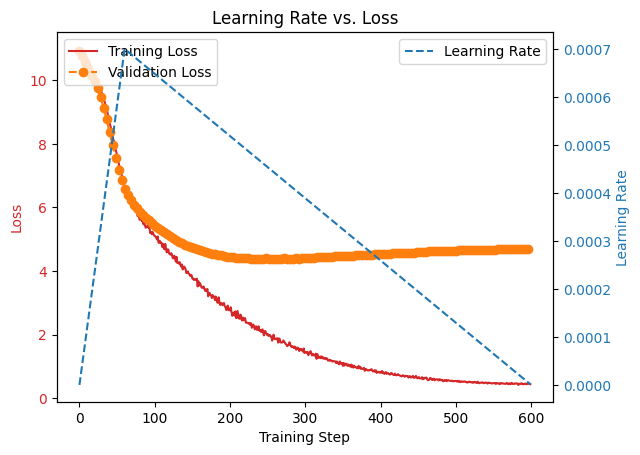

In [33]:
from matplotlib import pyplot as plt

# Ensure all histories are properly formatted
assert len(lr_history) == len(
    loss_history
), "Length of lr_history and loss_history must be the same"

# Create figure and primary y-axis for Loss
fig, ax1 = plt.subplots()

ax1.set_title("Learning Rate vs. Loss")
ax1.set_xlabel("Training Step")
ax1.set_ylabel("Loss", color="tab:red")
ax1.plot(range(len(loss_history)), loss_history, color="tab:red", label="Training Loss")
ax1.tick_params(axis="y", labelcolor="tab:red")

# Plot validation loss (assuming it occurs every 'epoch_interval' steps)
epoch_interval = len(loss_history) // len(val_loss_history)
val_x = [
    i * epoch_interval for i in range(len(val_loss_history))
]  # X values for validation loss
ax1.plot(
    val_x,
    val_loss_history,
    color="tab:orange",
    marker="o",
    linestyle="dashed",
    label="Validation Loss",
)

# Create secondary y-axis for Learning Rate
ax2 = ax1.twinx()
ax2.set_ylabel("Learning Rate", color="tab:blue")
ax2.plot(
    range(len(lr_history)),
    lr_history,
    color="tab:blue",
    linestyle="--",
    label="Learning Rate",
)
ax2.tick_params(axis="y", labelcolor="tab:blue")

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

# Model inference

In [34]:
def inference(input, tokenizer, model, max_length=TGT_MAX_SEQ):
    """
    Translates a single Polish sentence into Ukrainian using greedy decoding.
    """
    model.eval()  # Set the model to evaluation mode

    tokens = tokenizer.encode(input)
    tokens = torch.tensor(tokens).unsqueeze(0).to(device)  # Shape: (1, seq_len)
    # print(tokens)

    # Start with the input sentence and an empty target sequence
    src_data = tokens
    tgt_data = torch.tensor([tokenizer.bos_token_id]).unsqueeze(0).to(device)

    with torch.no_grad():
        for _ in range(max_length):
            output = model(src_data, tgt_data)

            next_token_id = output[:, -1, :].argmax(dim=-1).item()

            tgt_data = torch.cat([tgt_data, torch.tensor([[next_token_id]]).to(device)], dim=1)

            if next_token_id == tokenizer.eos_token_id:
                break

    # Decode the token ids back to the sentence
    translated_tokens = tgt_data.squeeze().tolist()
    translated_sentence = tokenizer.decode(translated_tokens, skip_special_tokens=True)

    return translated_sentence


def inference_from_datasets(train_dataset: bool = True, index: int = 0) -> (str, str):
    if train_dataset:
        dataset = train_loader.dataset
    else:
        dataset = val_loader.dataset
    src_input = tokenizer.decode(dataset[index][0].tolist(), skip_special_tokens=True)
    translation = inference(src_input, tokenizer, transformer)

    print('Dataset:', 'Train' if train_dataset else 'Validation')
    print('Src:', src_input)
    print('Generated translation:', translation)
    real_translation = tokenizer.decode(dataset[index][1].tolist(), skip_special_tokens=True)
    print('Real translation:      ', real_translation)
    return src_input, translation, real_translation

<!-- # SacreBLEU metrics -->

In [39]:
import evaluate
import httpx
# Load metrics
rouge = evaluate.load("rouge")
sacrebleu = evaluate.load("sacrebleu")
meteor = evaluate.load("meteor")
chrf = evaluate.load("chrf")
bleu = evaluate.load("bleu")

[nltk_data] Downloading package wordnet to
[nltk_data]     D:\Users\mlaudan\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt_tab to
[nltk_data]     D:\Users\mlaudan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     D:\Users\mlaudan\AppData\Roaming\nltk_data...


In [ ]:

# Docs: https://huggingface.co/spaces/evaluate-metric/sacrebleu
# score from 0 to 100
local_accuracy = 0.0
deepl_accuracy = 0.0

def compute(predictions, references):
    # Predictions and references
    predictions = [predictions]
    references = [[references]]

    # Compute all metrics
    results_rouge = rouge.compute(predictions=predictions, references=references)  # ROUGE expects list of strings
    results_sacrebleu = sacrebleu.compute(predictions=predictions, references=references)
    results_meteor = meteor.compute(predictions=predictions, references=references)
    results_chrf = chrf.compute(predictions=predictions, references=references)
    results_bleu = bleu.compute(predictions=predictions, references=references)
    return results_rouge['rouge1']

    # Print results
    # print("\n📊 Translation Metrics:")
    # print(f"ROUGE-1 (0–1):        {results_rouge['rouge1']:.4f}")  # Overlap of unigrams (single words) between the generated and reference texts.
    # print(f"ROUGE-2 (0–1):        {results_rouge['rouge2']:.4f}")  # Overlap of bigrams (word pairs).
    # print(f"ROUGE-L (0–1):        {results_rouge['rougeL']:.4f}")  # Measures longest common subsequence (sequence similarity).
    # print(f"SacreBLEU (0–100):    {results_sacrebleu['score']:.2f}")  # Precision-based score for how many matching words/phrases, adjusted for brevity.
    # print(f"METEOR (0–1):         {results_meteor['meteor']:.4f}")  #  Considers word matches, stemming, and synonyms with penalties for word order.
    # print(f"chrF (0–100):         {results_chrf['score']:.2f}")  # Measures character-level n-gram overlap (more sensitive to small variations).
    # print(f"BLEU (0–100):         {results_bleu['bleu']:.2f}")  # Measures n-gram overlap between generated and reference texts.

n = 10
for i in range(n):
    src_input, predictions, references = inference_from_datasets(train_dataset=False, index=i)  # translation, real_translation


    json_data = {
        "text": [src_input], 
        "target_lang": "FR"
    }
    headers = {"Authorization": "DeepL-Auth-Key 8a886374-aa90-488e-8209-a000d7ac9e93:fx"}
    response = httpx.post("https://api-free.deepl.com/v2/translate", json=json_data, headers=headers)
    response = response.json()["translations"][0]["text"]
    print('Translation from DeepL:', response)

    local_accuracy += compute(predictions, references)
    print()
    deepl_accuracy += compute(predictions, response)

print('Local accuracy:', local_accuracy/n)
print('DeepL accuracy:', deepl_accuracy/n)

Dataset: Validation
Src: The telescope was still equipped with a metal mirror (not glass), and its optical qualities were considered less than optimal by that time.
Generated translation: Le télescope de 1, il département d'une réput spélescope Spatial et moy deux livres et scientifiques.
Real translation:       Le télescope est toutefois doté d'un miroir de métal (et non de verre) n'ayant pas de grandes qualités optiques.
Translation from DeepL: Le télescope était encore équipé d'un miroir en métal (et non en verre), et ses qualités optiques n'étaient pas considérées comme optimales à l'époque.
DEEEPL

Dataset: Validation
Src: The James Webb Space Telescope The successor to the Hubble Space Telescope
Generated translation: Le Télescope spatial FUSE est la recherche astronomique du Canada
Real translation:       Le Télescope Spatial James Webb Le successeur du télescope spatial Hubble
Translation from DeepL: Le télescope spatial James Webb Le successeur du télescope spatial Hubble
DEEE

KeyboardInterrupt: 

In [26]:
# PATH = r"new_translation_model.pt"
# torch.save(transformer.state_dict(), PATH)

In [27]:
# next_model = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_src_seq_len,
#                          max_tgt_seq_len, dropout)
# next_model.load_state_dict(torch.load(PATH, weights_only=True))
# next_model = next_model.to(device)
# # print(next_model)

# # sentence = tokenizer.decode(train_loader.dataset[0][0].tolist(), skip_special_tokens=True)
# sentence = "What are light beans there?"
# print(sentence)
# # sentence = "Prehistoric humans studied the relationship between the seasons and the length of days to plan their hunting and gathering activities."
# translation = translate_sentence(sentence, tokenizer, next_model)
# print(translation)